# EDA + Data Cleansing

In [196]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

In [197]:
sys.path.append(os.path.join('..', 'src'))

In [198]:
import importlib
import utils, params
importlib.reload(utils)
from utils import capture_data

importlib.reload(params)
from params import ProjectParameters

# set image building to True/False
* if build_images == False: faster to run, but images won't be generated

In [199]:
build_images = False

# define functions

In [200]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions related to missing data

In [201]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    
    return missing_data

def drop_missing_from_threshold(df, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing
    # use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30):
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df, k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
        
    else:
        print('error: select a correct method for imputation')
        
    return df

### functions related to outliers

In [202]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))

    df['outlier'] = outlier_pred
    df = df[df['outlier'] == 1]
    df.drop(['outlier'], axis=1, inplace=True)
    
    return df

def remove_outliers(df, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):
    # separate numerical data for treatment
    df_filtered = df[cols]
    
    if method == 'isolation_forest':
        df_filtered = apply_isolation_forest(df_filtered, if_contamination)
    elif method == 'standard_deviation_tol':
        df_filtered = apply_standard_deviation_tol(df_filtered, z_tol)
    
    # reintegrate filtered numerical data into full dataset
    df_filtered.merge(df, how = 'inner', left_index=True, right_index=True)
    print(len(df_filtered))
    
    return df_filtered

# Define paths and capture data

In [203]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

# file = 'X_train.csv'
# y_file = 'y_train.csv'
# data = pd.read_csv(os.path.join(inputs, file), index_col='id')
# y_train = pd.read_csv(os.path.join(inputs, y_file), index_col='id')

In [204]:
data               = capture_data(inputs, 'X_train.csv')
data_test          = capture_data(inputs, 'X_test.csv')
y_train               = capture_data(inputs, 'y_train.csv')
y_test          = capture_data(inputs, 'y_test.csv')

In [205]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (5000, 13)


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,
14160,27,Private,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
27048,45,State-gov,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
28868,29,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
5667,30,Private,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
7827,29,Self-emp-not-inc,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


# numerical columns
numerical columns are: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [206]:
numerical_cols = ProjectParameters().numerical_cols

# Checking  for possible anomalies in the database

In [207]:
data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,38.793600,10.065000,1130.159400,87.180000,40.67960
std,13.688304,2.555246,7583.026928,406.812837,12.26164
min,17.000000,1.000000,0.000000,0.000000,1.00000
25%,28.000000,9.000000,0.000000,0.000000,40.00000
50%,37.000000,10.000000,0.000000,0.000000,40.00000
75%,48.000000,12.000000,0.000000,0.000000,45.00000
max,90.000000,16.000000,99999.000000,4356.000000,99.00000


# missing data
usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

### drop columns and rows for threshold of missing

In [208]:
print('SORTED LIST OF MISSING VALUES')
df_missing = get_missing(data)
df_missing.sort_values(by='percent_missing', ascending=False).head(20)

SORTED LIST OF MISSING VALUES


,total,percent_missing
workclass,316,0.0632
occupation,316,0.0632
native_country,95,0.0190
age,0,0.0000
education,0,0.0000
education_num,0,0.0000
marital_status,0,0.0000
relationship,0,0.0000
race,0,0.0000
sex,0,0.0000


In [209]:
col_mis_threshold = 0.8
row_mis_threshold = 0.2

In [210]:
data = drop_missing_from_threshold(data, row_mis_threshold, col_mis_threshold)

5 rows and 0 columns were removed from database


### visualize some rows with missing
we already know that the critical columns are 'workclass', 'occupation' and 'native_country'

In [211]:
print('number of missing: ', data[data.isna().any(axis=1)].shape[0])
data[data.isna().any(axis=1)].tail()

number of missing:  401


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,
21666,18,NaN,10th,6,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
19311,21,NaN,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States
15286,70,NaN,Assoc-voc,11,Never-married,NaN,Not-in-family,White,Male,0,0,30,United-States
32088,21,NaN,HS-grad,9,Never-married,NaN,Other-relative,Asian-Pac-Islander,Female,0,0,24,United-States
24923,68,Private,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,18,NaN


### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [212]:
numerical_cols, other_cols = get_numerical_mask(data)

In [213]:
# imputation over numerical variables

data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
    data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data[other_cols].isnull().values.any():
    data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)

print('number of missing after imputation step:', data[data.isna().any(axis=1)].shape[0])

number of missing after imputation step: 0


In [214]:
# imputation over numerical variables
data_test[numerical_cols] = data_test[numerical_cols].astype(float)
if 'NaN' in data_test[numerical_cols].values:
    data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data_test[other_cols].isnull().values.any():
    data_test[other_cols] = apply_imputation(data_test[other_cols], method = 'mode', k = 30)

# outlier removal
remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

# Visualize pairwise relations
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [215]:
if build_images==True:
    data_vis = data[numerical_cols]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots.jpg'), bbox_inches = "tight")

We see that most distributions are skewed and non-negative. This requires some transformations which will be left for the next notebook (feature_engineering).

# Check if data is imbalanced
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

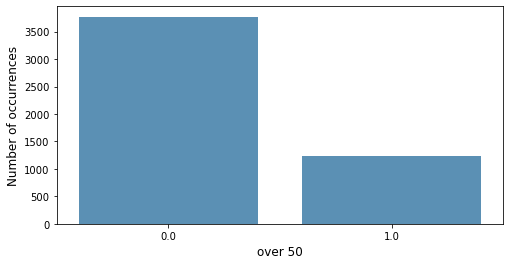

In [216]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('over 50', fontsize=12)
plt.show()

In [217]:
counts = y_train['y'].value_counts()
counts

0.0    3772
1.0    1228
Name: y, dtype: int64

In [218]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y_train['y'].value_counts(normalize=True)

ratio between classes: 3.07

Check proportions below:


0.0    0.7544
1.0    0.2456
Name: y, dtype: float64

# filter response variable based on data cleansing of independent variables

In [219]:
y_train = y_train.loc[data.index]
y_test = y_test.loc[data_test.index]

# Description (2nd round)

In [220]:
data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000
mean,38.791391,10.065265,1131.290691,86.933333,40.687287
std,13.679030,2.554364,7586.737685,406.393692,12.262265
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


# save intermediate data

In [221]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))

# test functions
Although unit tests would be more appropriate

##### apply test to imputation

In [222]:
test = pd.DataFrame(['NaN', 'NaN'])
test = pd.concat([data, test], ignore_index = True)
test['string_test'] = 'string'
# if 'NaN' in test.values:
if test.isnull().values.any():
    test = test.drop([0], axis=1)
    test[numerical_cols] = apply_imputation(test[numerical_cols], method = 'knn', k = 30)
    print('done imputation')
test.tail()

done imputation


,age,capital_gain,capital_loss,education,education_num,hours_per_week,marital_status,native_country,occupation,race,relationship,sex,workclass,string_test
4992,35.000000,0.000000,0.000000e+00,HS-grad,9.000000,40.000000,Divorced,United-States,Craft-repair,White,Unmarried,Male,Private,string
4993,32.000000,0.000000,0.000000e+00,Assoc-voc,11.000000,99.000000,Married-civ-spouse,United-States,Transport-moving,White,Husband,Male,Private,string
4994,26.000000,0.000000,0.000000e+00,HS-grad,9.000000,40.000000,Never-married,United-States,Handlers-cleaners,Black,Own-child,Male,Private,string
4995,43.555656,1093.410401,1.241370e-15,NaN,7.872816,33.892916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string
4996,43.555656,1093.410401,1.241370e-15,NaN,7.872816,33.892916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,string


In [223]:
data.shape

(4995, 13)